# TAOS mars3D: tides, inspect nonlinearity


In [1]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import xarray as xr
import pandas as pd

import dask
from dask import delayed

from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

import pytide

import taos.utils as ut
import taos.mars as ms

rad2deg = 180/np.pi

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(processes=4, cores=4) # std
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57485,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:55609,Total threads: 7
Dashboard: http://127.0.0.1:47897/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:58016,


---

## load data


Raw data:

In [3]:
ds2D = xr.open_zarr(os.path.join(ms.diag_dir, "fields_2d.zarr"))
ds2D = ds2D.sel(time="2014")
#ds2D

In [4]:
# station position
lon, lat = -.2, 49.4
idx = ms.get_horizontal_indices(ds2D, lon=lon, lat=lat)

ds = ds2D.sel(**idx["rho"], 
              ni_u=idx["u"]["ni_u"], 
              nj_v=idx["v"]["nj_v"],
)

In [5]:
# load tidal amplitudes
zarr = os.path.join(ms.diag_dir, "fields_2d_tide.zarr")
h = xr.open_zarr(zarr)

h = h.sel(**idx["rho"], 
          ni_u=idx["u"]["ni_u"], 
          nj_v=idx["v"]["nj_v"],
).compute()

In [6]:
for v in h:
    ds[v+"_tide"] = ut.predict_tides(ds.time, har=h[v], real=True, summed=True,)
ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:       (time: 8760)
Coordinates: (12/13)
    latitude      float64 49.4
    latitude_u    float64 49.4
    latitude_v    float64 49.4
    level         float32 -0.0125
    longitude     float64 -0.1988
    longitude_u   float64 -0.2021
    ...            ...
    ni            float32 188.0
    ni_u          float32 187.5
    nj            float32 35.0
    nj_v          float32 34.5
  * time          (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
    time_seconds  (time) float64 1.389e+09 1.389e+09 ... 1.42e+09 1.42e+09
Data variables: (12/14)
    SAL_surf      (time) float32 34.07 34.11 34.14 34.17 ... 31.43 31.46 31.41
    TEMP_surf     (time) float32 9.807 9.838 9.845 9.852 ... 8.007 7.939 7.962
    U             (time) float32 -0.4096 -0.4456 -0.3779 ... -0.374 -0.3241
    UZ_surf       (time) float32 -0.4255 -0.488 -0.4155 ... -0.4853 -0.3515
    V             (time) float32 0.1906 0.1376 0.08438 ... 0.1546 0.1393 0.08658
    VZ_surf       (time) float32 0.2999 0.2198 0.173 ... 0.3205 0.4245 0.4572
    ...            ...
    sigma0_surf   (time) float64 26.14 26.16 26.19 26.21 ... 24.36 24.4 24.36
    U_tide        (time) float64 -0.441 -0.4771 -0.4217 ... -0.345 -0.3067
    UZ_surf_tide  (time) float64 -0.4959 -0.5806 -0.5267 ... -0.3361 -0.3145
    V_tide        (time) float64 0.2117 0.1795 0.1109 ... 0.1569 0.1367 0.08698
    VZ_surf_tide  (time) float64 0.2692 0.2817 0.2393 ... 0.1931 0.2178 0.2001
    XE_tide       (time) float64 0.1194 -1.597 -2.75 ... -0.09236 -1.368 -2.305
Attributes: (12/55)
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    arakawa_grid_type:       C1
    area:                    SEINE
    comment:                 Use of Meteo-France AROME meteorological data
    contact:                 cdoco-exploit@ifremer.fr
    creation_date:           2019-08-17T19:43:27Z
    ...                      ...
    source:                  MARS MANGAE2500-AGRIF
    southernmost_latitude:   49.2424
    start_date:              2018-12-29T00:00:00Z
    stop_date:               2018-12-29T00:00:00Z
    title:                   MARC F1 MANGAE2500 AGRIF hindcast
    westernmost_longitude:   -1.4598

### Time series

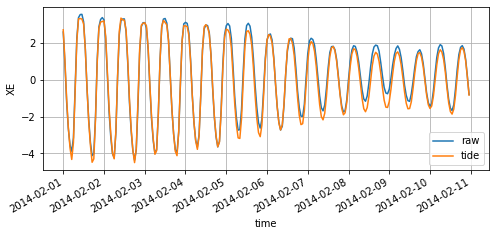

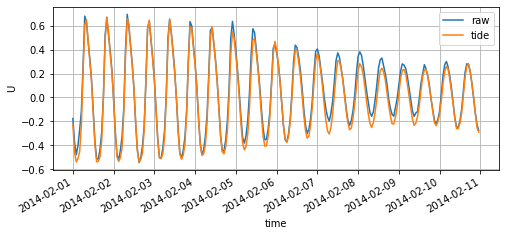

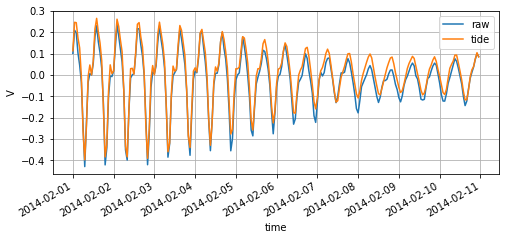

In [7]:
t = slice("2014-02-01", "2014-02-10")
_ds = ds.sel(time=t)

for v in ["XE", "U", "V"]:
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    _ds[v].plot(ax=ax, label="raw")
    _ds[v+"_tide"].plot(ax=ax, label="tide")
    ax.legend()
    ax.grid()
    ax.set_title("")
    ax.set_ylabel(v)

### Hodograph

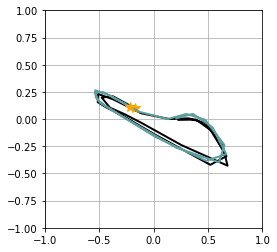

In [8]:
def hodo(ds, v=["U", "V"], tide=True):
    fig, ax = plt.subplots(1,1)

    ax.plot(ds[v[0]], ds[v[1]], color="k", lw=2)
    ax.plot(ds[v[0]].isel(time=0), ds[v[1]].isel(time=0), "*", color="orange", markersize=10)

    if tide:
        ax.plot(ds[v[0]+"_tide"], ds[v[1]+"_tide"], color="cadetblue", lw=2)
        ax.plot(ds[v[0]+"_tide"].isel(time=0), ds[v[1]+"_tide"].isel(time=0), 
                "*", color="orange", markersize=10)
    
    lims = (-1., 1.)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid()
    ax.set_aspect("equal")
    
hodo(_ds.isel(time=slice(0,24)))

Decompose constituent contributions

In [11]:
V = ["XE", "U", "V", "UZ_surf", "VZ_surf"]
ds_cst = xr.merge([ut.predict_tides(ds.time, har=h[v], real=True, summed=False,).rename(v+"_tide")
                   for v in V
                  ]
                  +[ds[v] for v in V]
                 ).compute()
ds_cst

<xarray.Dataset>
Dimensions:        (constituent: 67, time: 8760)
Coordinates: (12/16)
  * constituent    (constituent) <U7 'O1' 'P1' 'K1' '2N2' ... 'MSf' 'Ssa' 'Sa'
    frequency      (constituent) float64 0.9295 0.9973 ... 0.005476 0.002738
    frequency_rad  (constituent) float64 6.76e-05 7.252e-05 ... 1.991e-07
    latitude       float64 49.4
    latitude_u     float64 49.4
    latitude_v     float64 49.4
    ...             ...
    ni             float32 188.0
    ni_u           float32 187.5
    nj             float32 35.0
    nj_v           float32 34.5
  * time           (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
    time_seconds   (time) float64 1.389e+09 1.389e+09 ... 1.42e+09 1.42e+09
Data variables:
    XE_tide        (constituent, time) float64 0.04387 0.04606 ... 0.03425
    U_tide         (constituent, time) float64 0.002284 0.001906 ... 0.001308
    V_tide         (constituent, time) float64 0.0001158 0.0004862 ... 0.0004745
    UZ_surf_tide   (constituent, time) float64 0.004877 0.004194 ... 0.01248
    VZ_surf_tide   (constituent, time) float64 -0.002095 -0.002115 ... 0.02734
    XE             (time) float32 0.1662 -1.506 -2.667 ... -0.3366 -1.598 -2.474
    U              (time) float32 -0.4096 -0.4456 -0.3779 ... -0.374 -0.3241
    V              (time) float32 0.1906 0.1376 0.08438 ... 0.1393 0.08658
    UZ_surf        (time) float32 -0.4255 -0.488 -0.4155 ... -0.4853 -0.3515
    VZ_surf        (time) float32 0.2999 0.2198 0.173 ... 0.3205 0.4245 0.4572

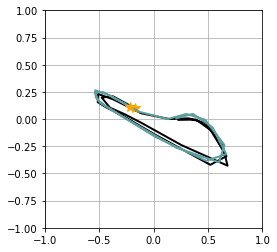

In [13]:
_ds = ds_cst.sel(time=t)
_ds = _ds.sum("constituent")
hodo(_ds.isel(time=slice(0,24)))

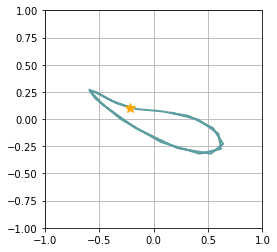

In [14]:
_ds = ds_cst.sel(time=t)
_ds = _ds.where( _ds.frequency<4.5 , drop=True).sum("constituent")
hodo(_ds.isel(time=slice(0,24)))

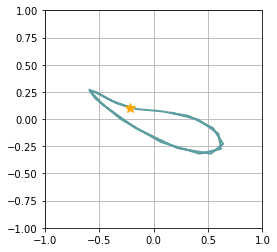

In [15]:
_ds = ds_cst.sel(time=t)
_ds = _ds.where( _ds.frequency<5.5 , drop=True).sum("constituent")
hodo(_ds.isel(time=slice(0,24)))

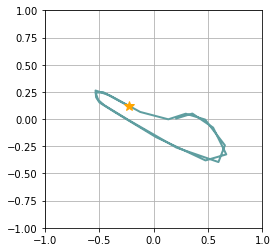

In [16]:
_ds = ds_cst.sel(time=t)
_ds = _ds.where( _ds.frequency<6.5 , drop=True).sum("constituent")
hodo(_ds.isel(time=slice(0,24)))

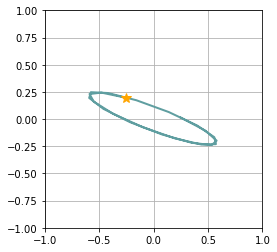

In [12]:
_ds = ds_cst.sel(time=t)
_ds = _ds.where( _ds.frequency<3.5 , drop=True).sum("constituent")
hodo(_ds.isel(time=slice(0,24)))

Constituents that matter are thus at 4cpd and 6cpd

### inspect timing between high, low sea level vs current tides

In [42]:
t = slice("2014-08-01", "2014-08-20")
_ds = ds.sel(time=t)
_ds = _ds.resample(time="5T").interpolate() # 5min

# recompute tides
_ds = xr.merge([ut.predict_tides(_ds.time, har=h[v], real=True, summed=True,)
                .rename(v+"_tide")
                for v in V
               ]
               +[_ds[v] for v in V]
              ).compute()
_ds

<xarray.Dataset>
Dimensions:       (time: 5749)
Coordinates: (12/13)
    latitude      float64 49.4
    latitude_u    float64 49.4
    latitude_v    float64 49.4
    level         float32 -0.0125
    longitude     float64 -0.1988
    longitude_u   float64 -0.2021
    ...            ...
    ni            float32 188.0
    ni_u          float32 187.5
    nj            float32 35.0
    nj_v          float32 34.5
  * time          (time) datetime64[ns] 2014-08-01 ... 2014-08-20T23:00:00
    time_seconds  (time) float64 1.407e+09 1.407e+09 ... 1.409e+09 1.409e+09
Data variables:
    XE_tide       (time) float64 2.684 2.668 2.65 2.631 ... -1.388 -1.433 -1.476
    U_tide        (time) float64 0.2022 0.1898 0.1774 ... -0.2464 -0.2427
    V_tide        (time) float64 0.05422 0.05382 0.05318 ... 0.03818 0.03544
    UZ_surf_tide  (time) float64 0.267 0.2522 0.2372 ... -0.3665 -0.3617 -0.3566
    VZ_surf_tide  (time) float64 -0.01849 -0.01776 -0.01729 ... 0.135 0.1355
    XE            (time) float64 2.499 2.483 2.466 2.45 ... -1.534 -1.592 -1.649
    U             (time) float64 0.2155 0.2006 0.1857 ... -0.2409 -0.2399
    V             (time) float64 0.02059 0.02134 0.02208 ... 0.07335 0.07156
    UZ_surf       (time) float64 0.2386 0.2231 0.2077 ... -0.2372 -0.2366
    VZ_surf       (time) float64 0.02204 0.02395 0.02587 ... 0.1011 0.1011

In [43]:
colors = dict(XE=dict(raw="k", tide="0.5"),
              U=dict(raw="r", tide="orange"),
              V=dict(raw="blue", tide="cadetblue"),
              UV=dict(raw="green", tide="cyan"),
             )

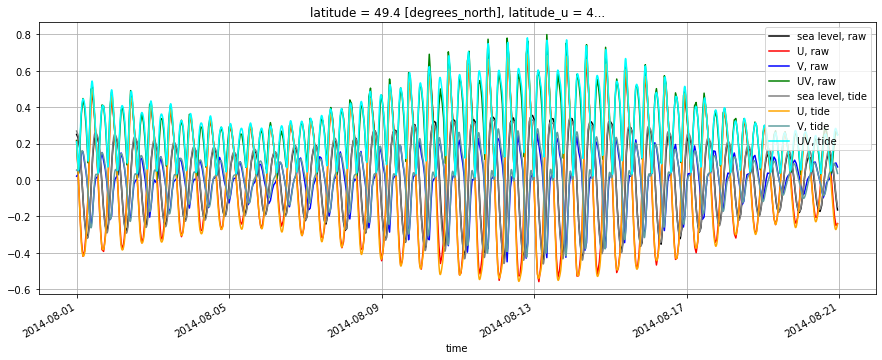

In [47]:
def tseries(ds, tide=True, raw=True):

    fig, ax = plt.subplots(1,1, figsize=(15,5))

    
    
    if raw:
        v = "XE"
        (ds[v]/10).plot(ax=ax, color=colors[v]["raw"], label="sea level, raw")
        #
        for v in ["U", "V"]:
            ds[v].plot(ax=ax, color=colors[v]["raw"], label=v+", raw")
        #
        UV = np.sqrt(ds["U"]**2+ds["V"]**2)
        v = "UV"
        UV.plot(ax=ax, color=colors[v]["raw"], label=v+", raw")
    
    if tide:
        v = "XE"
        (ds[v+"_tide"]/10).plot(ax=ax, color=colors[v]["tide"],label="sea level, tide")
        #
        for v in ["U", "V"]:
            ds[v+"_tide"].plot(ax=ax, color=colors[v]["tide"],label=v+", tide")
        #
        UV_tide = np.sqrt(ds["U_tide"]**2+ds["V_tide"]**2)
        v = "UV"
        UV_tide.plot(ax=ax, color=colors[v]["tide"], label=v+", tide")

    ax.legend()
    ax.grid()
    
tseries(_ds)

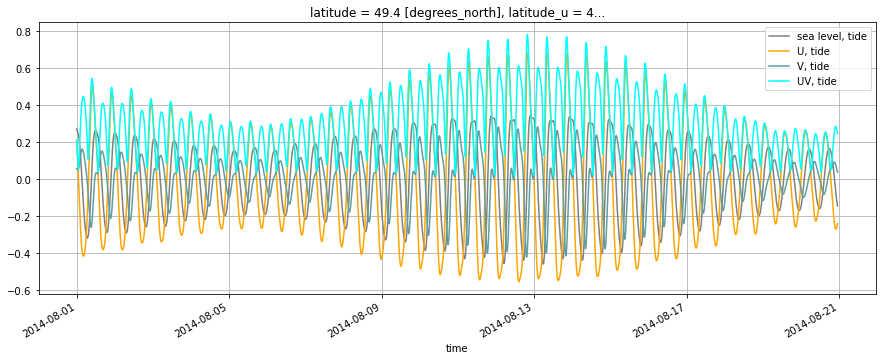

In [48]:
tseries(_ds, raw=False)

#### Neap tide

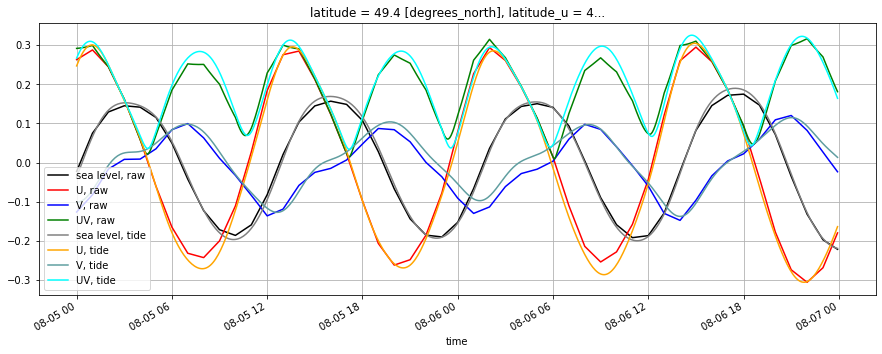

In [52]:
t = slice("2014-08-05", "2014-08-06")
tseries(_ds.sel(time=t), raw=True)

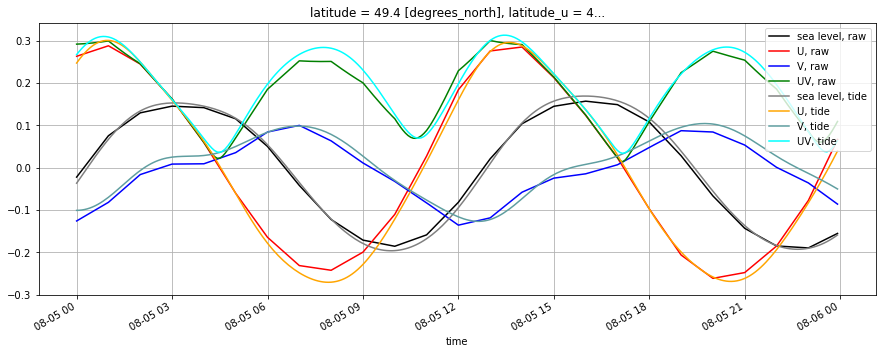

In [53]:
t = "2014-08-05"
tseries(_ds.sel(time=t), raw=True)

#### Spring tide

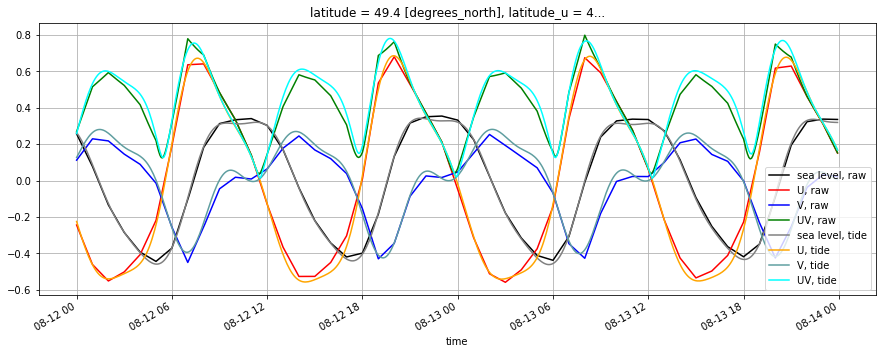

In [54]:
t = slice("2014-08-12", "2014-08-13")
tseries(_ds.sel(time=t), raw=True)

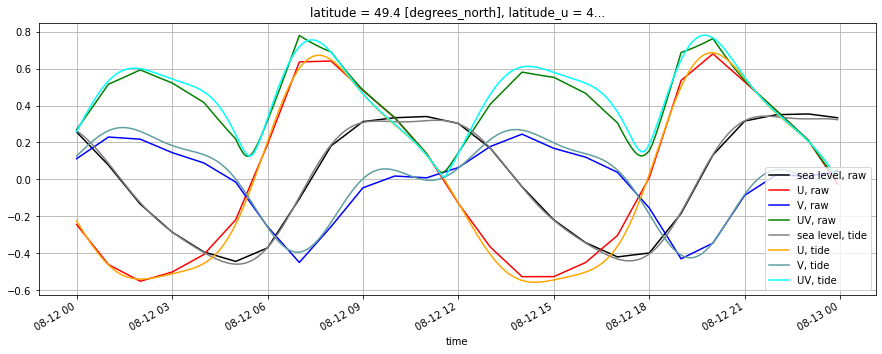

In [55]:
t = "2014-08-12"
tseries(_ds.sel(time=t), raw=True)

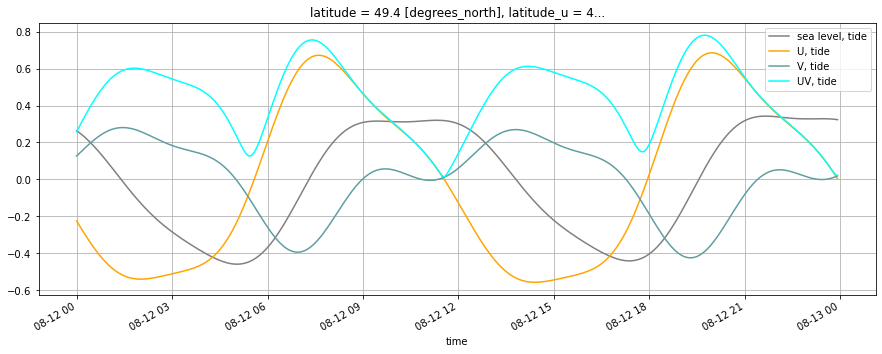

In [56]:
t = "2014-08-12"
tseries(_ds.sel(time=t), raw=False)

http://maree.info/25/calendrier?d=201511 

For August 2014:

Gives neap tide between the 5th and the 6th
Gives spring tide on the 13th

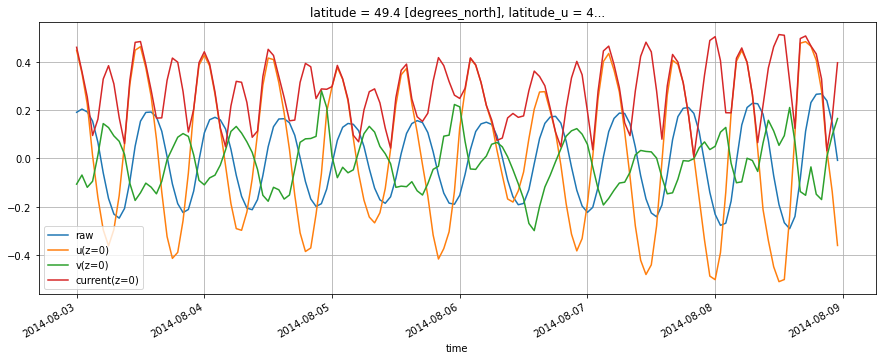

In [32]:
t = slice("2014-08-03", "2014-08-8")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

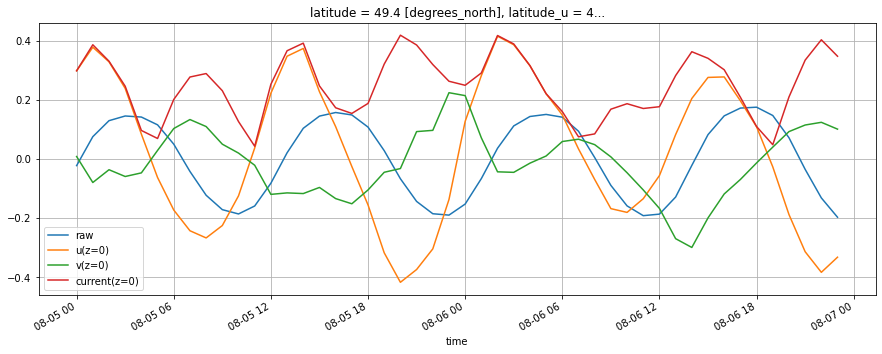

In [33]:
t = slice("2014-08-05", "2014-08-06")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

In [39]:
# about 45 min de décalage d'un jour à l'autre
T_M2 = 12.4206012 # hours
(T_M2 - 12) *24/T_M2 *60

48.76299611004338

There is an offset of about one hour between the simulation and [marée.info](http://maree.info/25?d=20140812)

High/low tides are most favorable.
High tides are longer and probably more favorable than lows.
The difference between high/low sea level and low current is less than 2 hours

---

In [ ]:
cluster.close()